Validation Results:
Accuracy: 0.7060
              precision    recall  f1-score       support
False          0.727605  0.891205  0.801138  19431.000000
True           0.611183  0.338874  0.436003   9806.000000
accuracy       0.705955  0.705955  0.705955      0.705955
macro avg      0.669394  0.615039  0.618571  29237.000000
weighted avg   0.688557  0.705955  0.678673  29237.000000


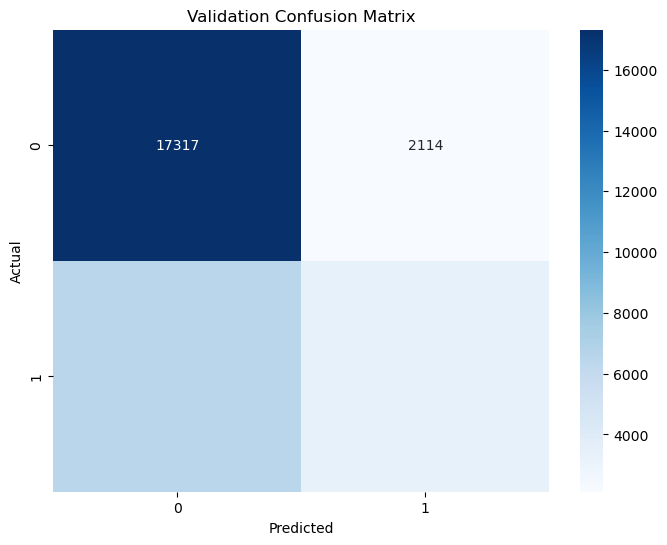


Test Results:
Accuracy: 0.7013
              precision    recall  f1-score       support
False          0.720704  0.892414  0.797420  38518.000000
True           0.615513  0.332448  0.431718  19955.000000
accuracy       0.701315  0.701315  0.701315      0.701315
macro avg      0.668109  0.612431  0.614569  58473.000000
weighted avg   0.684806  0.701315  0.672618  58473.000000


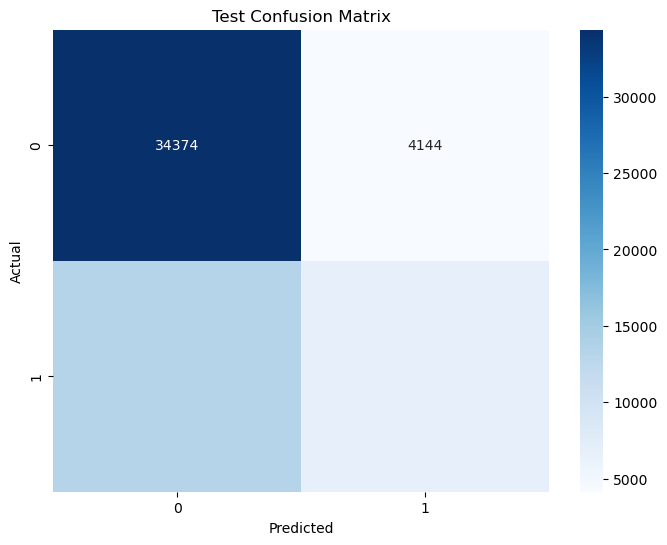

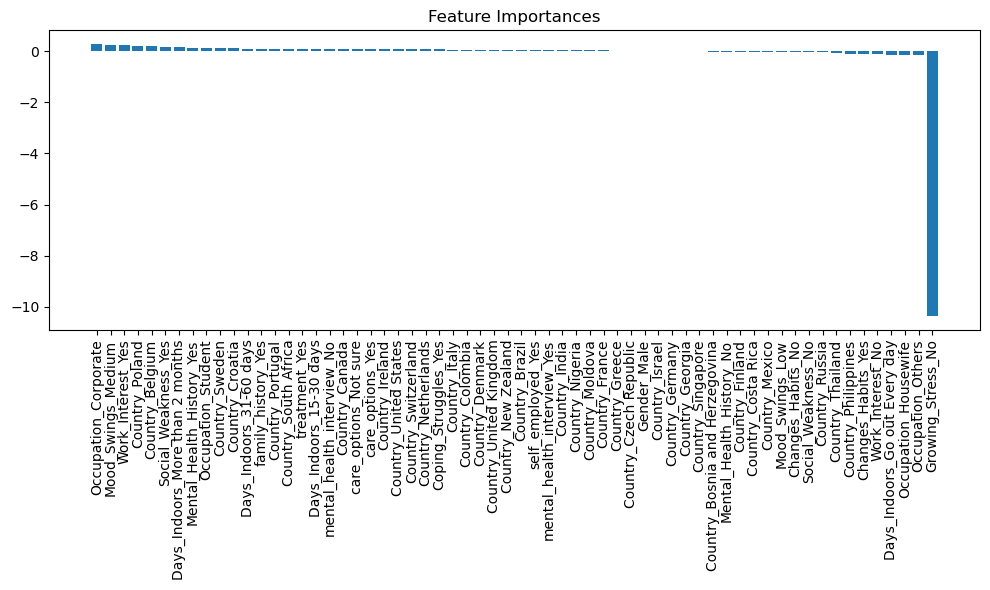

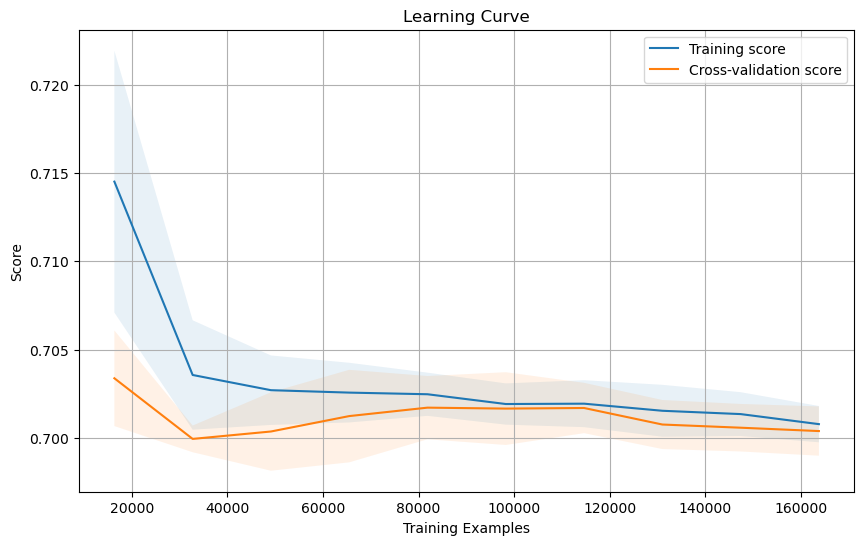


Prediction for example input: Yes


In [3]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, learning_curve
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

def load_data(filepath):
    data = pd.read_csv(filepath)
    data.drop(columns=['Timestamp'], inplace=True)
    data['self_employed'] = data['self_employed'].fillna(data['self_employed'].mode()[0])
    return data

def preprocess_data(data):
    return pd.get_dummies(data, drop_first=True)

def split_data(data_encoded):
    X = data_encoded.drop('Growing_Stress_Yes', axis=1)
    y = data_encoded['Growing_Stress_Yes']
    
    X_train_val, X_test, y_train_val, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    X_train, X_val, y_train, y_val = train_test_split(X_train_val, y_train_val, test_size=0.125, random_state=42)
    
    return X_train, X_val, X_test, y_train, y_val, y_test

def train_model(X_train, y_train):
    nb_model = MultinomialNB()
    nb_model.fit(X_train, y_train)
    return nb_model

def evaluate_model(model, X, y):
    y_pred = model.predict(X)
    accuracy = accuracy_score(y, y_pred)
    report = classification_report(y, y_pred, output_dict=True)
    return accuracy, report

def plot_confusion_matrix(y_true, y_pred, title):
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.title(title)
    plt.ylabel('Actual')
    plt.xlabel('Predicted')
    plt.show()

def plot_feature_importance(model, X):
    importances = model.feature_log_prob_[1] - model.feature_log_prob_[0]
    indices = np.argsort(importances)[::-1]
    
    plt.figure(figsize=(10, 6))
    plt.title("Feature Importances")
    plt.bar(range(X.shape[1]), importances[indices])
    plt.xticks(range(X.shape[1]), X.columns[indices], rotation=90)
    plt.tight_layout()
    plt.show()

def predict_growing_stress(model, X_columns, input_data):
    template_df = pd.DataFrame(columns=X_columns)
    template_df.loc[0] = 0
    input_df = pd.get_dummies(pd.DataFrame([input_data]))
    for column in input_df.columns:
        if column in template_df.columns:
            template_df.at[0, column] = input_df.at[0, column].astype(template_df[column].dtype)
    prediction = model.predict(template_df)
    return "Yes" if prediction[0] == 1 else "No"

def plot_learning_curve(X, y):
    train_sizes, train_scores, test_scores = learning_curve(
        MultinomialNB(), X, y, 
        cv=5, n_jobs=-1, train_sizes=np.linspace(0.1, 1.0, 10))
    
    train_mean = np.mean(train_scores, axis=1)
    train_std = np.std(train_scores, axis=1)
    test_mean = np.mean(test_scores, axis=1)
    test_std = np.std(test_scores, axis=1)

    plt.figure(figsize=(10, 6))
    plt.plot(train_sizes, train_mean, label='Training score')
    plt.plot(train_sizes, test_mean, label='Cross-validation score')
    plt.fill_between(train_sizes, train_mean - train_std, train_mean + train_std, alpha=0.1)
    plt.fill_between(train_sizes, test_mean - test_std, test_mean + test_std, alpha=0.1)
    plt.title('Learning Curve')
    plt.xlabel('Training Examples')
    plt.ylabel('Score')
    plt.legend(loc='best')
    plt.grid(True)
    plt.show()

def main():
    data = load_data('Dataset.csv')
    data_encoded = preprocess_data(data)
    
    X_train, X_val, X_test, y_train, y_val, y_test = split_data(data_encoded)
    
    nb_model = train_model(X_train, y_train)
    
    val_accuracy, val_report = evaluate_model(nb_model, X_val, y_val)
    print("Validation Results:")
    print(f"Accuracy: {val_accuracy:.4f}")
    print(pd.DataFrame(val_report).transpose())
    
    plot_confusion_matrix(y_val, nb_model.predict(X_val), "Validation Confusion Matrix")
    
    test_accuracy, test_report = evaluate_model(nb_model, X_test, y_test)
    print("\nTest Results:")
    print(f"Accuracy: {test_accuracy:.4f}")
    print(pd.DataFrame(test_report).transpose())
    
    plot_confusion_matrix(y_test, nb_model.predict(X_test), "Test Confusion Matrix")
    
    plot_feature_importance(nb_model, X_train)

    plot_learning_curve(X_train, y_train)
    
    input_data = {
        'Gender': 'Female',
        'Country': 'United States',
        'Occupation': 'Corporate',
        'self_employed': 'No',
        'family_history': 'No',
        'treatment': 'Yes',
        'Days_Indoors': '1-14 days',
        'Changes_Habits': 'No',
        'Mental_Health_History': 'Yes',
        'Mood_Swings': 'Medium',
        'Coping_Struggles': 'No',
        'Work_Interest': 'No',
        'Social_Weakness': 'Yes',
        'mental_health_interview': 'No',
        'care_options': 'Not sure'
    }
    prediction = predict_growing_stress(nb_model, X_train.columns, input_data)
    print(f"\nPrediction for example input: {prediction}")

if __name__ == '__main__':
    main()